In [7]:
import os
import re
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from rasterio.features import geometry_mask
from shapely.geometry import mapping
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from scipy import ndimage
from functools import partial

In [8]:

# =========================================================
# 2) TRÍCH DATETIME TỪ FILENAME
# =========================================================
def extract_datetime_from_filename(path):
    filename = os.path.basename(path)

    # Kiểu 1: CAPE_20190401000000.tif
    m14 = re.search(r"(\d{14})", filename)
    if m14:
        return pd.to_datetime(m14.group(1), format="%Y%m%d%H%M%S", errors="coerce")

    # Kiểu 2: B04B_20190401.Z0000_TB.tif
    m_date = re.search(r"(\d{8})", filename)
    m_z = re.search(r"Z(\d{4})", filename)

    if m_date:
        date = m_date.group(1)
        if m_z:
            return pd.to_datetime(date + m_z.group(1), format="%Y%m%d%H%M", errors="coerce")
        return pd.to_datetime(date, format="%Y%m%d", errors="coerce")

    return pd.NaT


# =========================================================
# 3) LIST FILE
# =========================================================
def list_all_files(root):
    out = []
    for dp, _, files in os.walk(root):
        for f in files:
            if f.endswith(".tif") or f.endswith(".TIF"):
                out.append(os.path.join(dp, f))
    return out

In [9]:

def fill_nodata_minus9999(arr):
    """
    Fill toàn bộ NaN / +Inf / -Inf thành -9999
    Nhanh, an toàn cho ML (XGBoost / CatBoost / LGBM)
    """
    arr = arr.astype(np.float32, copy=False)
    mask = np.isnan(arr) | np.isinf(arr)
    if mask.any():
        arr[mask] = -9999.0
    return arr

def get_variable_name(path):
    """
    Lấy tên biến từ filename.
    VD: 'B04B_2019....tif' -> trả về 'B04B'
    VD: 'CAPE_2019....tif' -> trả về 'CAPE'
    """
    filename = os.path.basename(path)
    return filename.split('_')[0]

In [10]:
# =========================================================
# 1) LOAD SHAPEFILE HÀ TĨNH
# =========================================================
shp_path = "gadm41_VNM_shp"
vnm_gdf = gpd.read_file(shp_path)

# Lọc Hà Tĩnh
th_gdf = vnm_gdf[vnm_gdf['VARNAME_1'] == 'Thanh Hoa']

th_union = th_gdf.geometry.union_all()
th_crs = th_gdf.crs

In [38]:
def extract_HaTinh_bbox_all_pixels(path, root):

    try:
        with rasterio.open(path) as src:
            data = src.read(1).astype(float)
            nodata = src.nodata
            transform = src.transform
            src_crs = src.crs

        # --- chuẩn hóa NODATA ---
        data[data == nodata] = np.nan
        data[data == -9999] = np.nan
        data[np.isinf(data)] = np.nan

        # --- fill nodata ---
        data = fill_nodata_minus9999(data)

        # --- reproject geometry ---
        if src_crs != th_crs:
            geom = th_gdf.to_crs(src_crs).geometry.union_all()
        else:
            geom = th_union

        # --- BƯỚC 1: Loose bbox ---
        bbox = geom.bounds
        min_row_loose, min_col_loose = rasterio.transform.rowcol(transform, bbox[0], bbox[3])
        max_row_loose, max_col_loose = rasterio.transform.rowcol(transform, bbox[2], bbox[1])

        min_row_loose = int(max(0, min_row_loose))
        min_col_loose = int(max(0, min_col_loose))
        max_row_loose = int(min(data.shape[0] - 1, max_row_loose))
        max_col_loose = int(min(data.shape[1] - 1, max_col_loose))

        # --- BƯỚC 2: Mask trong loose bbox ---
        height_loose = max_row_loose - min_row_loose + 1
        width_loose = max_col_loose - min_col_loose + 1

        window_transform = rasterio.windows.transform(
            rasterio.windows.Window(min_col_loose, min_row_loose, width_loose, height_loose),
            transform
        )

        mask_subset = geometry_mask(
            [mapping(geom)],
            invert=True,  # True = pixel center nằm trong tỉnh
            out_shape=(height_loose, width_loose),
            transform=window_transform
        )

        # --- BƯỚC 3: Tight bbox theo pixel thật ---
        valid_rows, valid_cols = np.where(mask_subset)

        if len(valid_rows) == 0:
            print(f"WARNING: No pixel inside geometry: {path}")
            return pd.DataFrame()

        trim_min_r, trim_max_r = valid_rows.min(), valid_rows.max()
        trim_min_c, trim_max_c = valid_cols.min(), valid_cols.max()

        min_row = min_row_loose + trim_min_r
        max_row = min_row_loose + trim_max_r
        min_col = min_col_loose + trim_min_c
        max_col = min_col_loose + trim_max_c

        # --- BƯỚC 4: Lấy toàn bộ pixel trong tight bbox ---
        rows = np.arange(min_row, max_row + 1)
        cols = np.arange(min_col, max_col + 1)

        row_grid, col_grid = np.meshgrid(rows, cols, indexing='ij')
        rows_flat = row_grid.flatten()
        cols_flat = col_grid.flatten()

        vals = data[rows_flat, cols_flat]

        # ===== ĐIỂM QUAN TRỌNG: CẮT MASK THEO TIGHT BBOX =====
        mask_tight = mask_subset[
            trim_min_r:trim_max_r + 1,
            trim_min_c:trim_max_c + 1
        ].flatten()

        # Pixel ngoài tỉnh → gán -9999
        vals[~mask_tight] = -9999

        # --- tọa độ & metadata ---
        lons, lats = rasterio.transform.xy(transform, rows_flat, cols_flat, offset='center')
        ts = extract_datetime_from_filename(path)
        rel = os.path.relpath(path, root)
        var = rel.split(os.sep)[0]

        return pd.DataFrame({
            "variable": var,
            "timestamp": ts,
            "row": rows_flat,
            "col": cols_flat,
            "lon": lons,
            "lat": lats,
            "value": vals,
            "in_ha_tinh": mask_tight
        })

    except Exception as e:
        print("ERROR:", path, e)
        return pd.DataFrame()


In [44]:

# =========================================================
# 6) MAIN
# =========================================================
def tif2csv():

    out_csv = "csv_data/tri_an_thanh_hoa/RADAR_ThanhHoa_rec.csv"
    root = "DATA_SV/Precipitation/Radar"

    # out_csv = "csv_data/tri_an_thanh_hoa/HIMA_ThanhHoa_rec.csv"
    # root = "DATA_SV/Hima"

    # out_csv = "csv_data/tri_an_thanh_hoa/ERA5_ThanhHoa_rec.csv"
    # root = "DATA_SV/ERA5"

    os.makedirs(os.path.dirname(out_csv), exist_ok=True)

    files = list_all_files(root)
    print("Tổng file tìm thấy:", len(files))

    if os.path.exists(out_csv):
        os.remove(out_csv)

    func = partial(extract_HaTinh_bbox_all_pixels, root=root)
    results = []

    with ThreadPoolExecutor(max_workers=10) as pool:
        futures = [pool.submit(func, f) for f in files]

        for f in tqdm(as_completed(futures), total=len(futures), desc="Process"):
            try:
                df = f.result()
                if df is not None and not df.empty:
                    results.append(df)
            except Exception as e:
                print("Thread error:", e)

    if results:
        final = pd.concat(results, ignore_index=True)
        final.to_csv(out_csv, index=False)
        print("DONE! Tổng pixel =", len(final))
    else:
        print("Không có data.")

tif2csv()

Tổng file tìm thấy: 2487


Process: 100%|██████████| 2487/2487 [00:17<00:00, 143.80it/s]


DONE! Tổng pixel = 3551436


In [45]:
def create_x_y_selected_features(list_path, selected_features=None):
    """
    Phiên bản tối ưu: Sửa lỗi index float, cố định thứ tự band và tăng tốc độ xử lý.
    """
    if selected_features is None:
        selected_features = ['B04B', 'B10B', 'B11B', 'B16B', 'IRB',
                             'CAPE', 'R850', 'TCWV', 'U850', 'I2B', 'TCLW', 'TCW']

    # 1) Đọc CSV và gộp
    dfs = []
    print("[B1] Đọc CSV...")
    for p in tqdm(list_path, desc="Đọc file CSV"):
        # Mẹo: Xác định dtype ngay lúc đọc để tiết kiệm bộ nhớ nếu file lớn
        df = pd.read_csv(p)
        df["variable"] = df["variable"].astype(str)
        # Gán nhãn y
        df.loc[df["variable"].isin(['2019', '2020']), "variable"] = 'y'
        dfs.append(df)

    df_all = pd.concat(dfs, ignore_index=True)

    # 2) Min/Max row/col → tạo hình chữ nhật
    min_row, max_row = df_all["row"].min(), df_all["row"].max()
    min_col, max_col = df_all["col"].min(), df_all["col"].max()
    n_row = int(max_row - min_row + 1)
    n_col = int(max_col - min_col + 1)

    # 3) Xác định danh sách band cần thiết (QUAN TRỌNG: Phải Sort để cố định thứ tự)
    required_bands_list = sorted(list(set(selected_features + ['y'])))
    required_bands_set = set(required_bands_list)
    print(f"-> Số lượng band bắt buộc: {len(required_bands_list)}")

    # 4) Lọc Timestamp hợp lệ (TỐI ƯU HÓA TỐC ĐỘ)
    print("[B2] Lọc timestamp đầy đủ (Vectorized Check)...")

    # Chỉ giữ lại các dòng thuộc các variable quan tâm để đếm cho nhanh
    df_check = df_all[df_all["variable"].isin(required_bands_set)]

    # Đếm số lượng variable unique trong mỗi timestamp
    # Nếu timestamp T1 có đủ 13 variable -> count sẽ là 13
    ts_counts = df_check.groupby("timestamp")["variable"].nunique()

    # Lấy ra các timestamp có số lượng variable bằng đúng số lượng yêu cầu
    valid_ts_index = ts_counts[ts_counts == len(required_bands_set)].index
    ts_valid = sorted(list(valid_ts_index))

    print(f"-> Tìm thấy {len(ts_valid)} timestamp hợp lệ.")

    # 5) Chuẩn bị dữ liệu để đổ vào Tensor
    print("[B3] Chuẩn bị index và Tensor...")

    # Tạo mapping index (Dictionary comprehension)
    t_to_idx = {t: i for i, t in enumerate(ts_valid)}
    b_to_idx = {b: i for i, b in enumerate(required_bands_list)} # Dùng list đã sort

    # Lọc dữ liệu chính thức:
    # - Chỉ lấy timestamp hợp lệ
    # - Chỉ lấy variable nằm trong required_bands (Bước này sửa lỗi Index Float)
    df_valid = df_all[
        (df_all["timestamp"].isin(ts_valid)) &
        (df_all["variable"].isin(required_bands_set))
    ].copy()

    # Map sang index (Ép kiểu int rõ ràng để tránh lỗi)
    df_valid["t_idx"] = df_valid["timestamp"].map(t_to_idx).astype(int)
    df_valid["b_idx"] = df_valid["variable"].map(b_to_idx).astype(int)
    df_valid["r_idx"] = (df_valid["row"] - min_row).astype(int)
    df_valid["c_idx"] = (df_valid["col"] - min_col).astype(int)

    # 6) Đổ dữ liệu vào Tensor (Vectorized - Không cần vòng lặp)
    print("[B4] Đổ dữ liệu vào Tensor...")
    # tensor = np.zeros((len(ts_valid), len(required_bands_list), n_row, n_col), dtype=float)

    tensor = np.full(
        (len(ts_valid), len(required_bands_list), n_row, n_col),
        -9999,
        dtype=float
    )

    # Numpy Advanced Indexing: Nhanh hơn loop rất nhiều
    tensor[df_valid["t_idx"].values,
           df_valid["b_idx"].values,
           df_valid["r_idx"].values,
           df_valid["c_idx"].values] = df_valid["value"].values

    # 7) Tách X và y
    y_idx = b_to_idx['y']
    # Lấy mảng X indices: loại bỏ index của y
    x_indices = [i for i, b in enumerate(required_bands_list) if b != 'y']

    y = tensor[:, [y_idx], :, :]
    x = tensor[:, x_indices, :, :]

    return x, y, ts_valid, required_bands_list, (min_row, max_row), (min_col, max_col)

In [28]:
import os

folder_path = os.path.join("csv_data", "tri_an_thanh_hoa")

if os.path.exists(folder_path):
    print(f"✅ Thư mục '{folder_path}' tồn tại.")
    print("👇 Các file bên trong là:")
    files = os.listdir(folder_path)
    for f in files:
        print(f"   - {f}")
else:
    print(f"❌ Không tìm thấy thư mục '{folder_path}'.")
    print("👇 Danh sách thư mục trong 'csv_data':")
    if os.path.exists("csv_data"):
        print(os.listdir("csv_data"))
    else:
        print("❌ Thư mục 'csv_data' cũng không thấy đâu!")

✅ Thư mục 'csv_data\tri_an_thanh_hoa' tồn tại.
👇 Các file bên trong là:
   - ERA5_ThanhHoa_rec.csv
   - HIMA_ThanhHoa_rec.csv
   - RADAR_ThanhHoa_rec.csv


In [46]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# 1. Định nghĩa đường dẫn Output (Lưu ý: bỏ ../ và dùng đuôi .npy)
output_X = "csv_data/tri_an_thanh_hoa/x_ThanhHoa_rec.npy"
output_Y = 'csv_data/tri_an_thanh_hoa/y_ThanhHoa_rec.npy'

def luuTensor():
    # 2. Định nghĩa danh sách file Input chính xác
    # (Bỏ ../ ở đầu, và dùng đúng tên file có đuôi _rec.csv)
    list_file = [
        'csv_data/tri_an_thanh_hoa/HIMA_ThanhHoa_rec.csv',
        'csv_data/tri_an_thanh_hoa/ERA5_ThanhHoa_rec.csv',
        'csv_data/tri_an_thanh_hoa/RADAR_ThanhHoa_rec.csv'
    ]

    print(f"Đang xử lý {len(list_file)} file...")

    # Gọi hàm xử lý (Đảm bảo hàm này đã được define ở cell trước đó)
    x, y, timestamps, x_bands, row_range, col_range = create_x_y_selected_features(list_file)

    print("[B4] Lưu tensor...")
    print(f"-> Shape X: {x.shape}")
    print(f"-> Shape Y: {y.shape}")

    # Lưu file .npy
    np.save(output_X, x)
    np.save(output_Y, np.squeeze(y, axis=1))
    print("✅ Hoàn tất! Đã lưu file .npy thành công.")

# Chạy hàm
luuTensor()

Đang xử lý 3 file...
[B1] Đọc CSV...


Đọc file CSV: 100%|██████████| 3/3 [01:20<00:00, 26.81s/it]


-> Số lượng band bắt buộc: 13
[B2] Lọc timestamp đầy đủ (Vectorized Check)...
-> Tìm thấy 1223 timestamp hợp lệ.
[B3] Chuẩn bị index và Tensor...
[B4] Đổ dữ liệu vào Tensor...
[B4] Lưu tensor...
-> Shape X: (1223, 12, 34, 42)
-> Shape Y: (1223, 1, 34, 42)
✅ Hoàn tất! Đã lưu file .npy thành công.


In [47]:
xThanhHoa = np.load(output_X)
yThanhHoa = np.load(output_Y)

In [48]:
print(xThanhHoa.shape)
print(yThanhHoa.shape)

(1223, 12, 34, 42)
(1223, 34, 42)


In [49]:
import numpy as np

# 1. Đếm trong mảng Y (Lượng mưa)
count_y = np.sum(yThanhHoa == -9999)
total_y = yThanhHoa.size
percent_y = (count_y / total_y) * 100

print(f"--- THỐNG KÊ Y (TARGET) ---")
print(f"Tổng số phần tử: {total_y}")
print(f"Số lượng -9999 : {count_y}")
print(f"Tỉ lệ NoData   : {percent_y:.4f}%")

# 2. Đếm trong mảng X (Input vệ tinh)
count_x = np.sum(xThanhHoa == -9999)
total_x = xThanhHoa.size
percent_x = (count_x / total_x) * 100

print(f"\n--- THỐNG KÊ X (INPUT) ---")
print(f"Tổng số phần tử: {total_x}")
print(f"Số lượng -9999 : {count_x}")
print(f"Tỉ lệ NoData   : {percent_x:.4f}%")

# 3. Kết luận nhanh
if count_x == 0 and count_y == 0:
    print("\n✅ TUYỆT VỜI! Bộ dữ liệu sạch hoàn toàn (Không có giá trị -9999 nào).")
else:
    print("\n⚠️ Bộ dữ liệu vẫn còn dính một số giá trị -9999.")

--- THỐNG KÊ Y (TARGET) ---
Tổng số phần tử: 1746444
Số lượng -9999 : 1017536
Tỉ lệ NoData   : 58.2633%

--- THỐNG KÊ X (INPUT) ---
Tổng số phần tử: 20957328
Số lượng -9999 : 12210432
Tỉ lệ NoData   : 58.2633%

⚠️ Bộ dữ liệu vẫn còn dính một số giá trị -9999.


xThanhHoa shape: (1223, 12, 34, 42)
yThanhHoa shape: (1223, 34, 42)


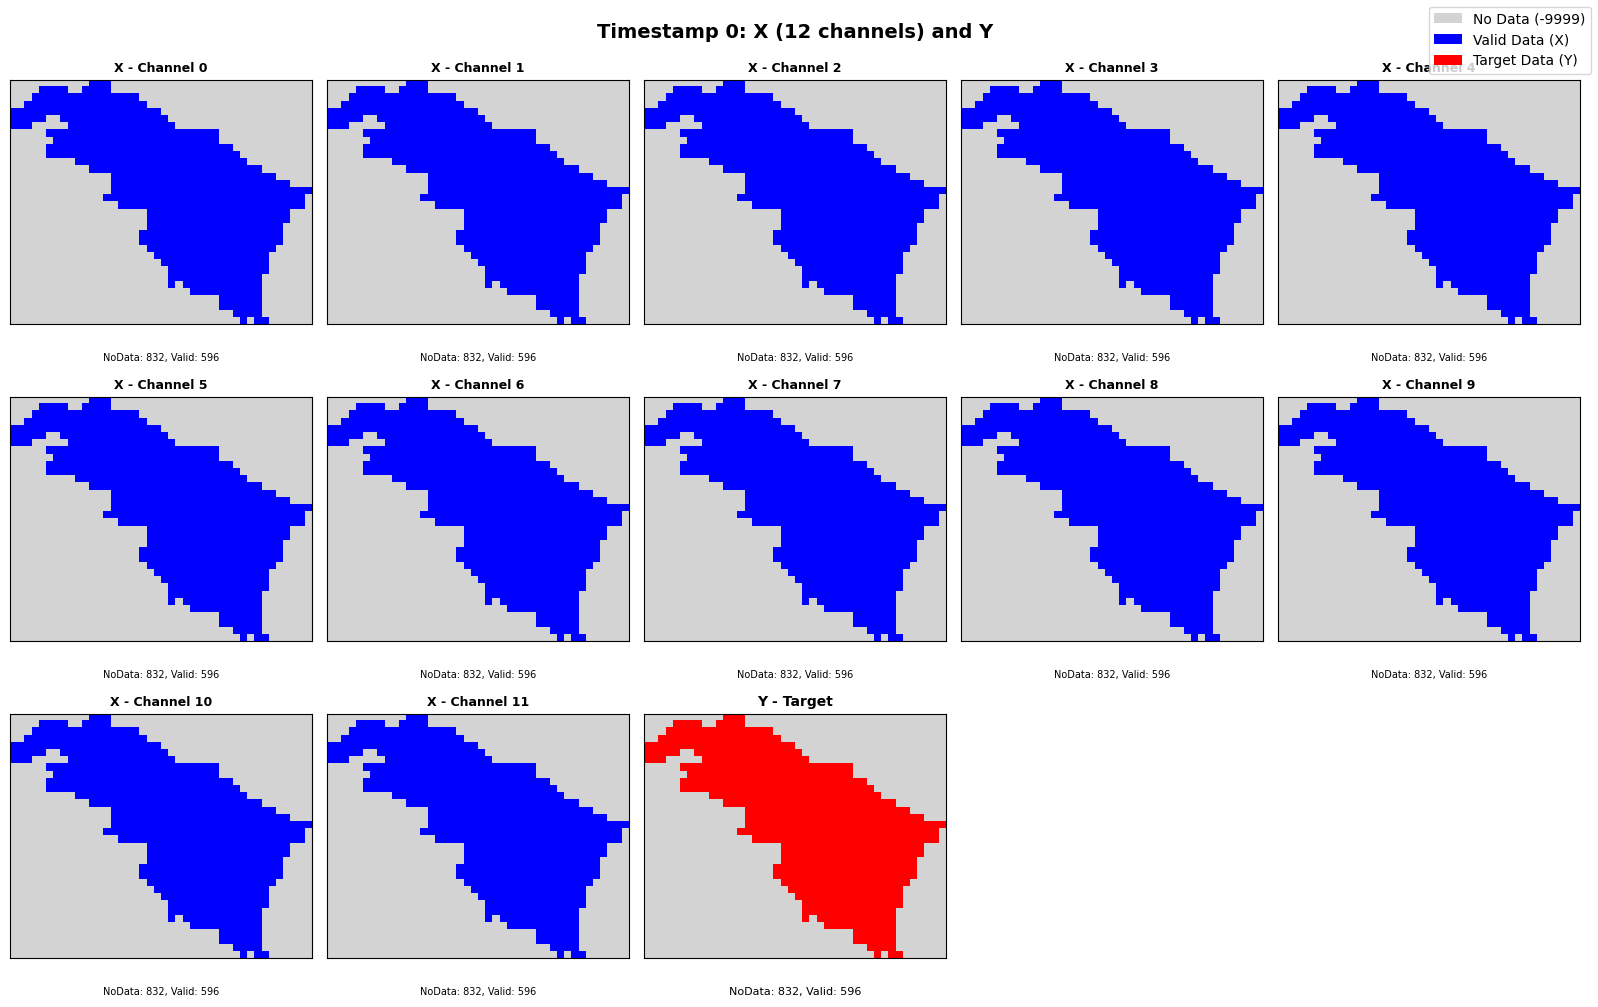


=== Timestamp 0 ===
X shape: (12, 34, 42)
Y shape: (34, 42)

Tổng NoData trong X: 9984/17136
Tổng Valid trong X: 7152/17136

NoData trong Y: 832/1428
Valid trong Y: 596/1428


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# # Load dữ liệu
# xThanhHoa = np.load('output_X.npy')
# yThanhHoa = np.load('output_Y.npy')

print(f"xThanhHoa shape: {xThanhHoa.shape}")
print(f"yThanhHoa shape: {yThanhHoa.shape}")

# Chọn 1 timestamp để xem
timestamp_idx = 0  # Thay đổi để xem timestamp khác (0-1222)

x_data = xThanhHoa[timestamp_idx]  # Shape: (12, 34, 42)
y_data = yThanhHoa[timestamp_idx]  # Shape: (34, 42)

# Tạo colormap: màu khác nhau cho -9999 và valid data
colors_nodata = ['lightgray', 'blue']  # Xám nhạt cho -9999, xanh cho valid
colors_target = ['lightgray', 'red']   # Xám nhạt cho -9999, đỏ cho target
cmap_x = ListedColormap(colors_nodata)
cmap_y = ListedColormap(colors_target)

def prepare_data(data):
    return np.where(data == -9999, 0, 1)

# Tạo figure: 12 channels của X + 1 Y = 13 subplots
fig = plt.figure(figsize=(16, 10))

# Vẽ 12 channels của X
for i in range(12):
    ax = plt.subplot(3, 5, i+1)
    plot_data = prepare_data(x_data[i])
    im = ax.imshow(plot_data, cmap=cmap_x, interpolation='nearest', vmin=0, vmax=1)
    ax.set_title(f'X - Channel {i}', fontsize=9, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

    # Thêm info
    n_nodata = np.sum(x_data[i] == -9999)
    n_valid = np.sum(x_data[i] != -9999)
    ax.text(0.5, -0.15, f'NoData: {n_nodata}, Valid: {n_valid}',
            transform=ax.transAxes, ha='center', fontsize=7)

# Vẽ Y
ax = plt.subplot(3, 5, 13)
plot_y = prepare_data(y_data)
im = ax.imshow(plot_y, cmap=cmap_y, interpolation='nearest', vmin=0, vmax=1)
ax.set_title(f'Y - Target', fontsize=10, fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])

n_nodata_y = np.sum(y_data == -9999)
n_valid_y = np.sum(y_data != -9999)
ax.text(0.5, -0.15, f'NoData: {n_nodata_y}, Valid: {n_valid_y}',
        transform=ax.transAxes, ha='center', fontsize=8)

# Thêm legend chung
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgray', label='No Data (-9999)'),
    Patch(facecolor='blue', label='Valid Data (X)'),
    Patch(facecolor='red', label='Target Data (Y)')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.suptitle(f'Timestamp {timestamp_idx}: X (12 channels) and Y',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# In thống kê
print(f"\n=== Timestamp {timestamp_idx} ===")
print(f"X shape: {x_data.shape}")
print(f"Y shape: {y_data.shape}")
print(f"\nTổng NoData trong X: {np.sum(x_data == -9999)}/{x_data.size}")
print(f"Tổng Valid trong X: {np.sum(x_data != -9999)}/{x_data.size}")
print(f"\nNoData trong Y: {np.sum(y_data == -9999)}/{y_data.size}")
print(f"Valid trong Y: {np.sum(y_data != -9999)}/{y_data.size}")

xThanhHoa shape: (1223, 12, 34, 42)
yThanhHoa shape: (1223, 34, 42)


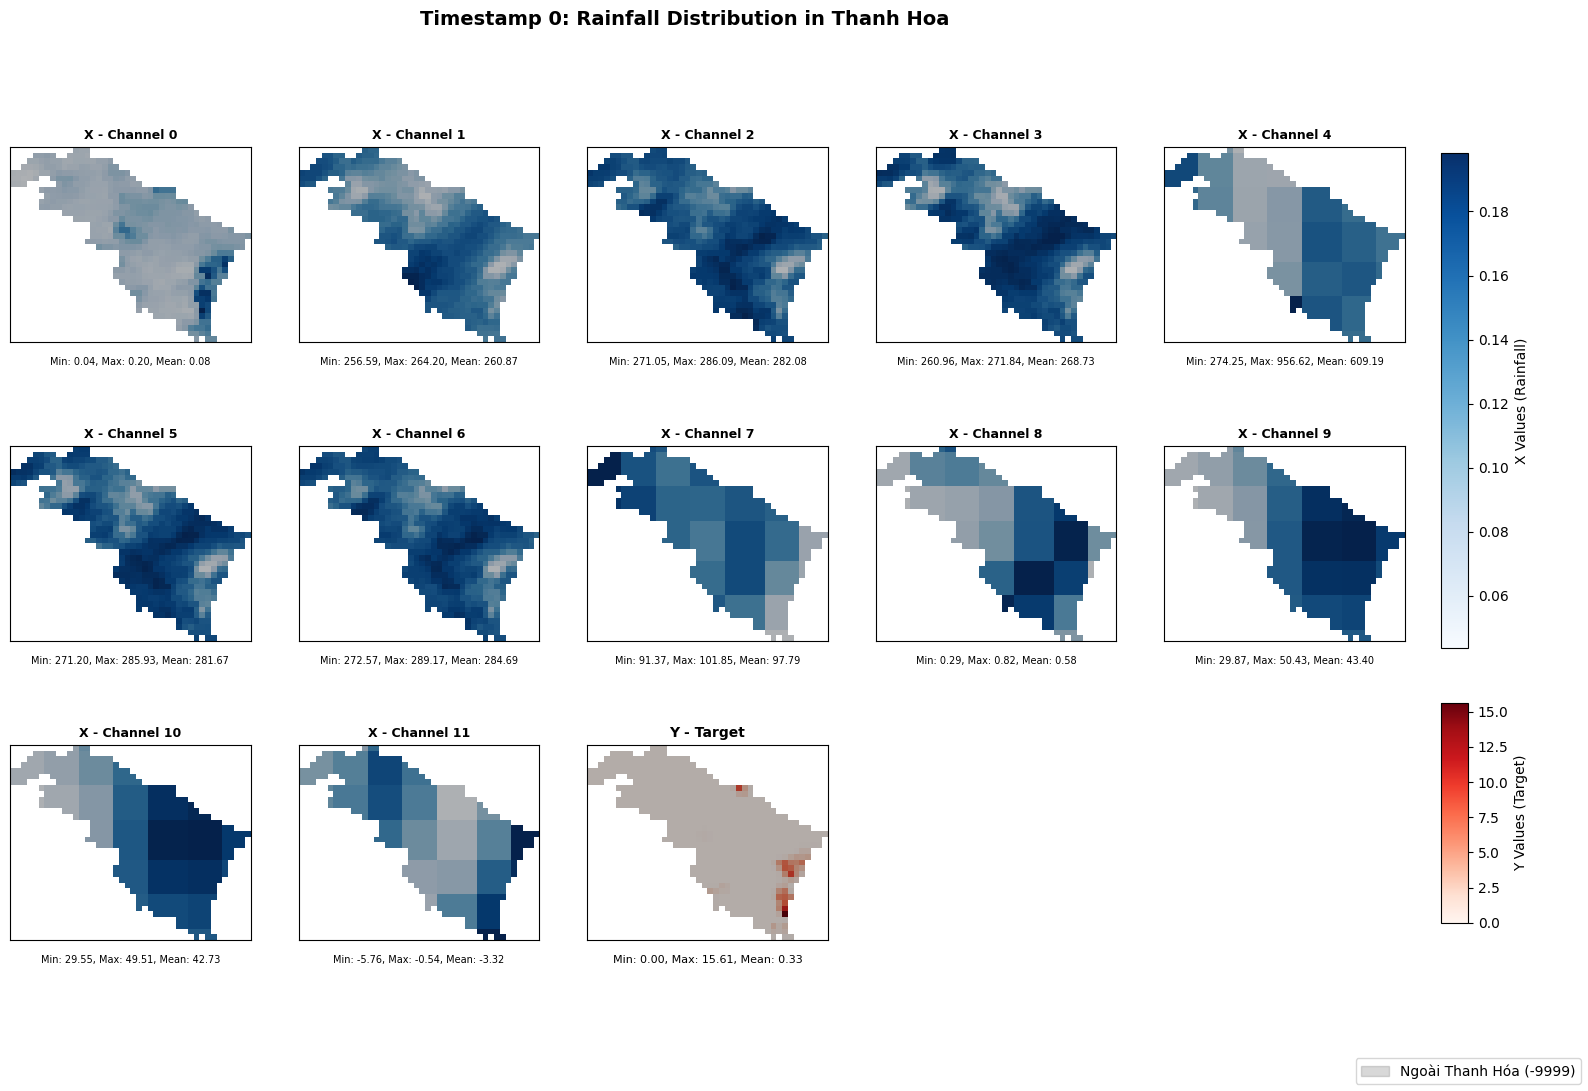


=== Timestamp 0 ===

X Channels:
  Channel 0: min=0.04, max=0.20, mean=0.08
  Channel 1: min=256.59, max=264.20, mean=260.87
  Channel 2: min=271.05, max=286.09, mean=282.08
  Channel 3: min=260.96, max=271.84, mean=268.73
  Channel 4: min=274.25, max=956.62, mean=609.19
  Channel 5: min=271.20, max=285.93, mean=281.67
  Channel 6: min=272.57, max=289.17, mean=284.69
  Channel 7: min=91.37, max=101.85, mean=97.79
  Channel 8: min=0.29, max=0.82, mean=0.58
  Channel 9: min=29.87, max=50.43, mean=43.40
  Channel 10: min=29.55, max=49.51, mean=42.73
  Channel 11: min=-5.76, max=-0.54, mean=-3.32

Y Target:
  min=0.00, max=15.61, mean=0.33

  NoData pixels: 832/1428
  Valid pixels: 596/1428


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

print(f"xThanhHoa shape: {xThanhHoa.shape}")
print(f"yThanhHoa shape: {yThanhHoa.shape}")

# Chọn 1 timestamp để xem
timestamp_idx = 0  # Thay đổi để xem timestamp khác (0-1222)

x_data = xThanhHoa[timestamp_idx]  # Shape: (12, 34, 42)
y_data = yThanhHoa[timestamp_idx]  # Shape: (34, 42)

# Hàm vẽ với colormap cho mưa
def plot_rainfall(data, ax, title):
    # Tạo masked array: mask vùng -9999
    masked_data = np.ma.masked_where(data == -9999, data)

    # Vẽ với colormap mưa (Blues, viridis, YlGnBu, etc.)
    im = ax.imshow(masked_data, cmap='Blues', interpolation='nearest')

    # Vẽ vùng -9999 bằng màu xám
    nodata_mask = (data == -9999)
    ax.imshow(nodata_mask, cmap='gray', alpha=0.3, interpolation='nearest',
              vmin=0, vmax=1)

    ax.set_title(title, fontsize=9, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

    # Thống kê
    valid_data = data[data != -9999]
    if len(valid_data) > 0:
        info_text = f'Min: {valid_data.min():.2f}, Max: {valid_data.max():.2f}, Mean: {valid_data.mean():.2f}'
    else:
        info_text = 'No valid data'
    ax.text(0.5, -0.12, info_text, transform=ax.transAxes,
            ha='center', fontsize=7)

    return im

# Tạo figure: 12 channels của X + 1 Y
fig = plt.figure(figsize=(18, 11))

# Vẽ 12 channels của X
ims = []
for i in range(12):
    ax = plt.subplot(3, 5, i+1)
    im = plot_rainfall(x_data[i], ax, f'X - Channel {i}')
    if i == 0:
        ims.append(im)

# Vẽ Y với colormap khác (ví dụ: Reds cho target)
ax = plt.subplot(3, 5, 13)
masked_y = np.ma.masked_where(y_data == -9999, y_data)
im_y = ax.imshow(masked_y, cmap='Reds', interpolation='nearest')
nodata_mask_y = (y_data == -9999)
ax.imshow(nodata_mask_y, cmap='gray', alpha=0.3, interpolation='nearest',
          vmin=0, vmax=1)
ax.set_title('Y - Target', fontsize=10, fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])

valid_y = y_data[y_data != -9999]
if len(valid_y) > 0:
    info_y = f'Min: {valid_y.min():.2f}, Max: {valid_y.max():.2f}, Mean: {valid_y.mean():.2f}'
else:
    info_y = 'No valid data'
ax.text(0.5, -0.12, info_y, transform=ax.transAxes, ha='center', fontsize=8)

# Thêm colorbar cho X và Y
cbar_ax1 = fig.add_axes([0.92, 0.4, 0.015, 0.45])
cbar1 = fig.colorbar(ims[0], cax=cbar_ax1)
cbar1.set_label('X Values (Rainfall)', fontsize=10)

cbar_ax2 = fig.add_axes([0.92, 0.15, 0.015, 0.2])
cbar2 = fig.colorbar(im_y, cax=cbar_ax2)
cbar2.set_label('Y Values (Target)', fontsize=10)

# Legend
gray_patch = mpatches.Patch(color='gray', alpha=0.3, label='Ngoài Thanh Hóa (-9999)')
fig.legend(handles=[gray_patch], loc='lower right', fontsize=10)

plt.suptitle(f'Timestamp {timestamp_idx}: Rainfall Distribution in Thanh Hoa',
             fontsize=14, fontweight='bold', y=0.98)
plt.subplots_adjust(right=0.9)
plt.show()

# In thống kê chi tiết
print(f"\n=== Timestamp {timestamp_idx} ===")
print(f"\nX Channels:")
for i in range(12):
    valid = x_data[i][x_data[i] != -9999]
    if len(valid) > 0:
        print(f"  Channel {i}: min={valid.min():.2f}, max={valid.max():.2f}, mean={valid.mean():.2f}")

print(f"\nY Target:")
if len(valid_y) > 0:
    print(f"  min={valid_y.min():.2f}, max={valid_y.max():.2f}, mean={valid_y.mean():.2f}")
print(f"\n  NoData pixels: {np.sum(y_data == -9999)}/{y_data.size}")
print(f"  Valid pixels: {np.sum(y_data != -9999)}/{y_data.size}")